# Predicting the winner of a baseball game

The game of baseball generates a large amount of data. Teams use data to rate players and identify trends. This notebook uses the data available before a game to predict which team will win. Readers should have a basic understanding of baseball to follow along. The first step is to import the necessary Python packages and set display options.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import display, HTML
%matplotlib inline

pd.set_option('display.max_columns', 200)

# display dataframe as a table
def print_table(df):
    display(HTML(df.to_html()))
    
# print info about table
def print_table_info(df, name):
    print(f"Table: {name}")
    print(f"Rows: {df.shape[0]}")
    print(f"Null values: {df.isnull().sum().sum()}")

## Retrosheet notice

<a href="https://www.retrosheet.org/" target="_blank">Retrosheet</a> game logs and event logs supply the data used in this notebook. The data is from 2000 to 2018 (19 seasons). Retrosheet asks data recipients to post the following <a href="https://www.retrosheet.org/notice.txt" target="_blank">notice</a>:

> The information used here was obtained free of charge from and is copyrighted by Retrosheet. Interested parties may contact Retrosheet at <a href="https://www.retrosheet.org/" target="_blank">"www.retrosheet.org"</a>.

## Import game logs

A Retrosheet game log has 161 columns of data for each game. This includes the date, teams, runs scored, starting lineups and starting pitchers. See the <a href="https://www.retrosheet.org/gamelogs/glfields.txt" target="_blank">guide to Retrosheet game logs</a> for a description of each column. New columns are also created based on the imported data. Each row of a Retrosheet game log has the data for 1 game.

In [2]:
# import the game logs from 2000 to 2018
game_log = pd.read_csv("retro/gl_00_18.txt", dtype={0:str, 1:str, 13:str, 15:str, 85:str, 87:str}, header=None)

# match column names with game log guide
game_log.columns += 1

# add new columns not included by Retrosheet
game_log[162] = game_log[7].str.cat(game_log[[1, 2]]) # game_id
game_log[163] = pd.to_datetime(game_log[162].str.slice(3) + "0", format='%Y%m%d%H', errors='coerce') # datetime

print_table(game_log.head())
print_table_info(game_log, "game_log")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163
0,20000329,0,Wed,CHN,NL,1,NYN,NL,1,5,3,54,N,NaN,NaN,NaN,TOK01,55000.0,206,100010210,001000020,33,12,1,0,2,5,1,0,1,10,0,5,1,0,4,0,13,3,3,3,0,0,27,10,2,0,1,0,33,7,1,0,1,3,1,1,0,3,0,4,0,0,1,0,8,5,5,5,1,0,27,12,0,0,4,0,marsr901,Randy Marsh,herna901,Angel Hernandez,fostm901,Marty Foster,kulpr901,Ron Kulpa,NaN,(none),NaN,(none),bayld001,Don Baylor,valeb102,Bobby Valentine,liebj001,Jon Lieber,hampm001,Mike Hampton,aguir001,Rick Aguilera,andrs001,Shane Andrews,liebj001,Jon Lieber,hampm001,Mike Hampton,youne001,Eric Young,4,bufod001,Damon Buford,8,gracm001,Mark Grace,3,sosas001,Sammy Sosa,9,rodrh001,Henry Rodriguez,7,andrs001,Shane Andrews,5,nievj002,Jose Nieves,6,giraj001,Joe Girardi,2,liebj001,Jon Lieber,1,hendr001,Rickey Henderson,7,hamid001,Darryl Hamilton,8,alfoe001,Edgardo Alfonzo,4,piazm001,Mike Piazza,2,ventr001,Robin Ventura,5,belld001,Derek Bell,9,zeilt001,Todd Zeile,3,ordor001,Rey Ordonez,6,hampm001,Mike Hampton,1,NaN,Y,NYN200003290,2000-03-29
1,20000330,0,Thu,NYN,NL,2,CHN,NL,2,5,1,66,N,NaN,NaN,NaN,TOK01,55000.0,235,00001000004,00001000000,37,6,2,0,1,5,1,1,1,8,0,5,1,0,0,0,10,5,0,0,0,0,33,14,2,0,2,0,36,5,0,0,0,0,2,0,0,6,1,9,0,0,2,0,10,7,5,5,0,0,33,14,0,0,0,0,herna901,Angel Hernandez,fostm901,Marty Foster,kulpr901,Ron Kulpa,marsr901,Randy Marsh,NaN,(none),NaN,(none),valeb102,Bobby Valentine,bayld001,Don Baylor,cookd001,Dennis Cook,yound002,Danny Young,NaN,(none),agbab001,Benny Agbayani,reedr002,Rick Reed,farnk001,Kyle Farnsworth,hendr001,Rickey Henderson,7,hamid001,Darryl Hamilton,8,alfoe001,Edgardo Alfonzo,4,piazm001,Mike Piazza,2,ventr001,Robin Ventura,5,belld001,Derek Bell,9,zeilt001,Todd Zeile,3,ordor001,Rey Ordonez,6,reedr002,Rick Reed,1,youne001,Eric Young,4,bufod001,Damon Buford,8,sosas001,Sammy Sosa,9,gracm001,Mark Grace,3,rodrh001,Henry Rodriguez,7,andrs001,Shane Andrews,5,husoj001,Jeff Huson,6,giraj001,Joe Girardi,2,farnk001,Kyle Farnsworth,1,NaN,Y,CHN200003300,2000-03-30
2,20000403,0,Mon,COL,NL,1,ATL,NL,1,0,2,51,D,NaN,NaN,NaN,ATL02,42255.0,134,000000000,00000020x,31,6,2,0,0,0,1,0,0,2,2,7,0,0,1,0,7,3,2,2,1,0,24,10,0,0,1,0,30,7,0,0,2,2,0,0,1,1,0,6,1,0,1,0,6,2,0,0,0,0,27,12,0,0,1,0,hirsj901,John Hirschbeck,willc901,Charlie Williams,wegnm901,Mark Wegner,reynj901,Jim Reynolds,NaN,(none),NaN,(none),bellb001,Buddy Bell,cox-b103,Bobby Cox,maddg002,Greg Maddux,astap001,Pedro Astacio,remlm001,Mike Remlinger,galaa001,Andres Galarraga,astap001,Pedro Astacio,maddg002,Greg Maddux,goodt001,Tom Goodwin,8,lansm001,Mike Lansing,4,walkl001,Larry Walker,9,cirij001,Jeff Cirillo,5,heltt001,Todd Helton,3,hammj001,Jeffrey Hammonds,7,peren001,Neifi Perez,6,maynb001,Brent Mayne,2,astap001,Pedro Astacio,1,veraq001,Quilvio Veras,4,sandr002,Reggie Sanders,7,jonec004,Chipper Jones,5,jordb001,Brian Jordan,9,galaa001,Andres Galarraga,3,jonea002,Andruw Jones,8,peree002,Eddie Perez,2,weisw001,Walt Weiss,6,maddg002,Greg Maddux,1,NaN,Y,ATL200004030,2000-04-03
3,20000403,0,Mon,MIL,NL,1,CIN,NL,1,3,3,31,D,NaN,NaN,NaN,CIN08,55596.0,111,002100,21000x,22,7,1,0,0,2,0,0,0,5,0,1,1,0,0,0,8,1,3,3,0,0,15,5,0,0,0,0,19,5,1,0,1,3,0,0,0,1,0,4,0,0,0,0,2,2,2,2,0,0,16,8,2,0,0,0,marsr901,Randy Marsh,herna901,Angel Hernandez,fostm901,Marty Foster,kulpr901,Ron Kulpa,NaN,(none),NaN,(none),loped001,Davey Lopes,mckej801,Jack McKeon,NaN,NaN,NaN,NaN,NaN,(none),NaN,(none),woods001,Steve Woodard,harnp001,Pete Harnisch,grism001,Marquis Grissom,8,lorem001,Mark Loretta,6,burnj001,Jeromy Burnitz,9,jenkg001,Geoff Jenkins,7,hernj001,Jose Hernandez,5,b

Table: game_log
Rows: 46159
Null values: 301824


## Model #1: Home field advantage

The `game_log` table has data to build models that predict the winner of each game. A simple model is based on <a href="https://en.wikipedia.org/wiki/Home_advantage" target="_blank">home field advantage</a>. This describes the various advantages the home team has over the away team. So, the model always predicts the home team will win. The accuracy of the model is the percentage of games the home team actually wins.

In [3]:
# did the home team score more runs? 
y = (game_log[11] - game_log[10]) > 0

print(f"Accuracy: {round(y.mean() * 100, 1)}%")

Accuracy: 53.9%


The home team won 53.9% of the games from 2000 to 2018. So, the model is correct over half of the time. This is good considering its simplicity. Yet, there is room for improvement. The model does not consider the quality of each team. Superior teams usually win against inferior teams regardless of home field advantage. A model that takes the quality of a team into account may be more accurate.

## Model #2: Team quality

This model uses the quality of each team to predict the winner of a game.

### Run differential

<a href="https://en.wikipedia.org/wiki/Run_differential" target="_blank">Run differential</a> measures the quality of a team. It is the number of runs scored minus the number of runs allowed by a team. In general, the greater the run differential the better the team. This predictor is prepared for the model in 5 steps:

- Collect run data
- Verify run data
- Compute run differential
- Combine run differential data
- Visualize run differential data

#### Collect run data

The `game_log` table has the runs scored by the home team and the away team for each game. The runs scored (rs) by a team equals the runs allowed (ra) by the other team. This determines each team's run differential for that game.

Each row of the `game_log` table has data for the home team and away team. Putting the teams in separate rows makes the data easier to analyze. The `home` table has run data for the home team. The `away` table has run data for the away team.

In [4]:
# get necessary columns from game log
def get_gl_cols(gl, cols, names):
    df = gl[cols].copy()
    df.columns = names
    return df

# runs scored and allowed by home team in each game
home = get_gl_cols(game_log, [162, 7, 163, 11, 10], ["game_id", "team", "date", "rs", "ra"])

print_table(home.head())
print_table_info(home, "home")

# runs scored and allowed by away team in each game
away = get_gl_cols(game_log, [162, 4, 163, 10, 11], ["game_id", "team", "date", "rs", "ra"])

print_table(away.head())
print_table_info(away, "away")

,game_id,team,date,rs,ra
0,NYN200003290,NYN,2000-03-29,3,5
1,CHN200003300,CHN,2000-03-30,1,5
2,ATL200004030,ATL,2000-04-03,2,0
3,CIN200004030,CIN,2000-04-03,3,3
4,FLO200004030,FLO,2000-04-03,6,4


Table: home
Rows: 46159
Null values: 0


,game_id,team,date,rs,ra
0,NYN200003290,CHN,2000-03-29,5,3
1,CHN200003300,NYN,2000-03-30,5,1
2,ATL200004030,COL,2000-04-03,0,2
3,CIN200004030,MIL,2000-04-03,3,3
4,FLO200004030,SFN,2000-04-03,4,6


Table: away
Rows: 46159
Null values: 0


The `total` table combines the rows of the `home` and `away` tables. Yet, unlike the `game_log` table, each row of the `total` table has the run data for only 1 team. For example, on March 29, 2000 the New York Mets scored 3 runs and allowed 5 runs. See the <a href="https://www.retrosheet.org/TEAMABR.TXT" target="_blank">Retrosheet team ID file</a> for a list of team abbreviations.

In [5]:
total = pd.concat([home, away], ignore_index=True)

print_table(total.head())
print_table_info(total, "total")

,game_id,team,date,rs,ra
0,NYN200003290,NYN,2000-03-29,3,5
1,CHN200003300,CHN,2000-03-30,1,5
2,ATL200004030,ATL,2000-04-03,2,0
3,CIN200004030,CIN,2000-04-03,3,3
4,FLO200004030,FLO,2000-04-03,6,4


Table: total
Rows: 92318
Null values: 0


#### Verify run data

The run totals for the league each year are compared to <a href="https://www.baseball-reference.com/leagues/MLB/2000.shtml" target="_blank">Baseball Reference</a>. The run totals for the Houston Astros each year are also compared.

In [6]:
print_table(total.groupby(total.date.dt.year).sum().loc[:, "rs":])
print_table(total.groupby(["team", total.date.dt.year]).sum().loc[["HOU"], "rs":])

,rs,ra
date,,
2000,24971,24971
2001,23199,23199
2002,22408,22408
2003,22978,22978
2004,23376,23376
2005,22325,22325
2006,23599,23599
2007,23322,23322
2008,22585,22585


The Retrosheet and Baseball Reference run data is the same. Similar results from 2 sources increases confidence in this data.

#### Compute run differential

The `total` table computes the runs a team has scored (rs_YTD) and allowed (ra_YTD) year-to-date. These columns determine a team's run differential year-to-date (rd_YTD). Note that run data for a game is not added to the year-to-date columns until the next game. This prevents data leakage.

Data leakage causes poor model performance. It occurs when the predictor data is not available at the time of prediction. Run differential year-to-date is the predictor for the model. So, it must be available before each game since the model predicts the winner at that time. The runs scored (rs) and allowed (ra) each game update the year-to-date amounts. Yet, this data is not available until after the game. So, the year-to-date columns are not updated with this data until the next game. 

Now, the `total` table has run data that is available before and after each game. For example, on April 8, 2000 the Anaheim Angels scored 7 runs and allowed 5 runs. Going into this game the team had a plus 7 run differential for the year.

In [7]:
def cumulative_rd(df):
    df["rs_YTD"] = df["rs"].cumsum().shift(1)
    df["ra_YTD"] = df["ra"].cumsum().shift(1)
    df["rd_YTD"] = df["rs_YTD"] - df["ra_YTD"]
    return df

total.sort_values(["team", "date"], inplace=True) # ensure games are in chronological order 
total = total.groupby([total.date.dt.year, "team"]).apply(cumulative_rd)
total.fillna(0, inplace=True) # no runs scored or allowed going into the 1st game of each year 

print_table(total.head())
print_table_info(total, "total")

,game_id,team,date,rs,ra,rs_YTD,ra_YTD,rd_YTD
8,ANA200004030,ANA,2000-04-03,2,3,0.0,0.0,0.0
20,ANA200004040,ANA,2000-04-04,3,5,2.0,3.0,-1.0
34,ANA200004050,ANA,2000-04-05,12,6,5.0,8.0,-3.0
61,ANA200004070,ANA,2000-04-07,7,3,17.0,14.0,3.0
76,ANA200004080,ANA,2000-04-08,7,5,24.0,17.0,7.0


Table: total
Rows: 92318
Null values: 0


#### Combine run differential data

The `home` and `away` tables add the year-to-date run data from the `total` table. The new columns in the `home` and `away` tables have 0 null values. So, there were no problems merging the data.

In [8]:
home = home.merge(total, how="left", on=["game_id", "team", "date", "rs", "ra"])

print_table(home.head())
print_table_info(home, "home")

away = away.merge(total, how="left", on=["game_id", "team", "date", "rs", "ra"])

print_table(away.head())
print_table_info(away, "away")

,game_id,team,date,rs,ra,rs_YTD,ra_YTD,rd_YTD
0,NYN200003290,NYN,2000-03-29,3,5,0.0,0.0,0.0
1,CHN200003300,CHN,2000-03-30,1,5,5.0,3.0,2.0
2,ATL200004030,ATL,2000-04-03,2,0,0.0,0.0,0.0
3,CIN200004030,CIN,2000-04-03,3,3,0.0,0.0,0.0
4,FLO200004030,FLO,2000-04-03,6,4,0.0,0.0,0.0


Table: home
Rows: 46159
Null values: 0


,game_id,team,date,rs,ra,rs_YTD,ra_YTD,rd_YTD
0,NYN200003290,CHN,2000-03-29,5,3,0.0,0.0,0.0
1,CHN200003300,NYN,2000-03-30,5,1,3.0,5.0,-2.0
2,ATL200004030,COL,2000-04-03,0,2,0.0,0.0,0.0
3,CIN200004030,MIL,2000-04-03,3,3,0.0,0.0,0.0
4,FLO200004030,SFN,2000-04-03,4,6,0.0,0.0,0.0


Table: away
Rows: 46159
Null values: 0


The `model_data` table adds the run data from the `home` and `away` tables for each game. The home team run differential year-to-date (rd_YTD_h) is a predictor. The away team run differential year-to-date (rd_YTD_a) is also a predictor. The other run data determines the actual winner of each game. The target (win) column is 1 if the home team won and 0 if the away team won. Now, the `model_data` table has the target and predictor data for each game. This is the data used to build and test the model.

In [9]:
model_data = home.merge(away, on=["game_id", "date"], suffixes=("_h", "_a"))
model_data["win"] = ((model_data["rs_h"] - model_data["rs_a"]) > 0).astype("int8") # did the home team score more runs?
model_data = model_data[["game_id", "date", "win", "rd_YTD_h", "rd_YTD_a"]] # remove unnecessary columns

print_table(model_data.head())
print_table_info(model_data, "model_data")

,game_id,date,win,rd_YTD_h,rd_YTD_a
0,NYN200003290,2000-03-29,0,0.0,0.0
1,CHN200003300,2000-03-30,0,2.0,-2.0
2,ATL200004030,2000-04-03,1,0.0,0.0
3,CIN200004030,2000-04-03,0,0.0,0.0
4,FLO200004030,2000-04-03,1,0.0,0.0


Table: model_data
Rows: 46159
Null values: 0


#### Visualize run differential data

The target and predictor data for each game can be visualized with a scatter plot. Each blue point is a game the home team won. Each orange point is a game the away team won. Ideally, the blue and orange points would be in separate clusters. This would make it easier to predict the winner of future games. Still, the scatter plot shows some separation. This may be enough to improve on the accuracy of the home field advantage model.

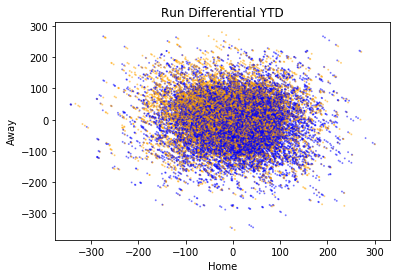

In [10]:
X = model_data[["rd_YTD_h", "rd_YTD_a"]].values # predictor data
y = model_data["win"].values # target data

colors = np.array(["orange", "blue"])
plt.scatter(X[:,0], X[:,1], alpha=0.4, c=colors[y], s=1)
plt.title("Run Differential YTD")
plt.xlabel("Home")
plt.ylabel("Away")
plt.show()

### Model accuracy 

<a href="https://machinelearningmastery.com/k-fold-cross-validation/" target="_blank">K-fold cross-validation</a> splits the `model_data` table rows into 10 groups.

The <a href="https://en.wikipedia.org/wiki/Naive_Bayes_classifier" target="_blank">Naive Bayes classifier</a> algorithm builds a model with training data. It evaluates the model's accuracy with test data. This process happens 10 times. The algorithm uses a new group as the test data each time. It uses the other 9 groups as the training data.

In [11]:
pipeline = Pipeline(steps=[("model", GaussianNB())])
kf = KFold(n_splits=10, shuffle=True, random_state=0)

scores = cross_val_score(pipeline, X, y, scoring="accuracy", cv=kf)

print(f"Accuracy: {round(scores.mean() * 100, 1)}%")

Accuracy: 55.8%


On average, the team quality model predicts the correct winner 55.8% of the time. Accuracy improved 1.9% over the home field advantage model. Yet, adding predictors may improve accuracy even more. Team quality is a function of the players on the team. So, a model that also takes player quality into account may be more accurate.

## Import event logs

Measuring player quality requires more specific data. A Retrosheet event log has 97 columns of data for each play in a game. This includes the batter, pitcher, base runners and a description of what happened on the play. See the <a href="https://www.retrosheet.org/datause.txt" target="_blank">guide to Retrosheet event logs (BEVENT)</a> for a description of each column. Retrosheet users can import a subset of these columns. Data from columns 0-1, 3, 10, 14, 26-29, 34, 36-40, 58-61, 66-71, 75-77 and 96 is used. New columns are also created based on the imported data. Each row of a Retrosheet event log has the data for 1 play in a game.

In [12]:
cols = ["game_id", "away", "bat_id", "batter", "pitcher", "first_runner", "second_runner", "third_runner", "desc", "event", "ab_flag", "hit_value", "sh_flag", "sf_flag", "num_outs", "bat_dest", "first_dest", "second_dest", "third_dest", "first_sb", "second_sb", "third_sb", "first_cs", "second_cs", "third_cs", "first_resp", "second_resp", "third_resp", "event_num"]
event_log = pd.read_csv("retro/el_00_18.txt", names=cols, header=None)

flags = ["ab_flag", "sh_flag", "sf_flag", "first_sb", "second_sb", "third_sb", "first_cs", "second_cs", "third_cs"]
event_log[flags] = event_log[flags].replace({"T":True, "F":False})

# add new columns not included by Retrosheet
event_log["date"] = pd.to_datetime(event_log["game_id"].str.slice(3) + "0", format='%Y%m%d%H', errors='coerce') # datetime
event_log["home"] = event_log["game_id"].str.slice(0,3) # home team
event_log["bat_team"] = event_log["home"] # team that is batting on the play
event_log["pitch_team"] = event_log["home"] # team that is pitching on the play

# add correct values to new columns
mask = (event_log["bat_id"] == 0)
event_log.loc[mask, "bat_team"] = event_log.loc[mask, "away"]
event_log.loc[~mask, "pitch_team"] = event_log.loc[~mask, "away"]

print_table(event_log.head())
print_table_info(event_log, "event_log")

,game_id,away,bat_id,batter,pitcher,first_runner,second_runner,third_runner,desc,event,ab_flag,hit_value,sh_flag,sf_flag,num_outs,bat_dest,first_dest,second_dest,third_dest,first_sb,second_sb,third_sb,first_cs,second_cs,third_cs,first_resp,second_resp,third_resp,event_num,date,home,bat_team,pitch_team
0,ANA200004030,NYA,0,knobc001,hillk001,NaN,NaN,NaN,S7/7S,20,True,1,False,False,0,1,0,0,0,False,False,False,False,False,False,NaN,NaN,NaN,1,2000-04-03,ANA,NYA,ANA
1,ANA200004030,NYA,0,jeted001,hillk001,knobc001,NaN,NaN,CS2(26),6,False,0,False,False,1,0,0,0,0,False,False,False,True,False,False,hillk001,NaN,NaN,2,2000-04-03,ANA,NYA,ANA
2,ANA200004030,NYA,0,jeted001,hillk001,NaN,NaN,NaN,63/G,2,True,0,False,False,1,0,0,0,0,False,False,False,False,False,False,NaN,NaN,NaN,3,2000-04-03,ANA,NYA,ANA
3,ANA200004030,NYA,0,oneip001,hillk001,NaN,NaN,NaN,W,14,False,0,False,False,0,1,0,0,0,False,False,False,False,False,False,NaN,NaN,NaN,4,2000-04-03,ANA,NYA,ANA
4,ANA200004030,NYA,0,willb002,hillk001,oneip001,NaN,NaN,46(1)/FO,2,True,0,False,False,1,1,0,0,0,False,False,False,False,False,False,hillk001,NaN,NaN,5,2000-04-03,ANA,NYA,ANA


Table: event_log
Rows: 3654530
Null values: 17296712


## Model #3: Team and player quality

This model uses team and player quality to predict the winner of a game. Run differential still measures the quality of a team. Runs created and adjusted pitching runs will measure the quality of a player.

### Runs created

<a href="https://en.wikipedia.org/wiki/Runs_created" target="_blank">Runs created</a> measures the quality of a player on offense. It estimates the number of runs a player contributes to the team. In general, the more runs created the better the player. This predictor is prepared for the model in 5 steps:

- Collect starting lineup data
- Collect player event data
- Verify player event data
- Compute runs created
- Combine starting lineup and runs created data

#### Collect starting lineup data

The starting lineup is a list of players that start a game. The lineup changes when a team substitutes a player during a game. The starting lineup for each team is available before a game. Lineup changes are not available before a game. A reliable model uses data that is available at the time of prediction. So, the model only uses runs created for players in the starting lineup as a predictor.

The `game_log` table has starting lineup data for each game. Each row has 18 players. 9 make up the home team's starting lineup. The other 9 make up the away team's starting lineup. Putting each of these players in a separate row makes the data easier to analyze. The `home_lineup` and `away_lineup` tables do this. The `home_lineup` table has the players that make up the home team's starting lineup for each game. The `away_lineup` table has the players that make up the away team's starting lineup for each game.

In [13]:
def clean_gl_lineup_data(gl, cols):
    df = gl[cols].copy()
    df.set_index(list(df.columns[:3]), inplace=True)
    df = df.stack()
    df = df.reset_index()
    df.columns = ["game_id", "team", "date", "type", "player"]
    df = df[["game_id", "team", "date", "player"]]
    return df

# home team players in the starting lineup
home_lineup = clean_gl_lineup_data(game_log, [162, 7, 163, 133, 136, 139, 142, 145, 148, 151, 154, 157])

print_table(home_lineup.head())
print_table_info(home_lineup, "home_lineup")

# away team players in the starting lineup
away_lineup = clean_gl_lineup_data(game_log, [162, 4, 163, 106, 109, 112, 115, 118, 121, 124, 127, 130])

print_table(away_lineup.head())
print_table_info(away_lineup, "away_lineup")

,game_id,team,date,player
0,NYN200003290,NYN,2000-03-29,hendr001
1,NYN200003290,NYN,2000-03-29,hamid001
2,NYN200003290,NYN,2000-03-29,alfoe001
3,NYN200003290,NYN,2000-03-29,piazm001
4,NYN200003290,NYN,2000-03-29,ventr001


Table: home_lineup
Rows: 415431
Null values: 0


,game_id,team,date,player
0,NYN200003290,CHN,2000-03-29,youne001
1,NYN200003290,CHN,2000-03-29,bufod001
2,NYN200003290,CHN,2000-03-29,gracm001
3,NYN200003290,CHN,2000-03-29,sosas001
4,NYN200003290,CHN,2000-03-29,rodrh001


Table: away_lineup
Rows: 415431
Null values: 0


The `total_lineup` table combines the rows of the `home_lineup` and `away_lineup` tables. Yet, unlike the `game_log` table, each row of the `total_lineup` table has only 1 player that started a game. For example, on March 29, 2000 the starting lineup for the New York Mets included:

- Rickey Henderson
- Darryl Hamilton
- Edgardo Alfonzo
- Mike Piazza
- Robin Ventura
- Derek Bell
- Todd Zeile
- Rey Ordonez
- Mike Hampton

See the <a href="https://www.retrosheet.org/retroID.htm" target="_blank">Retrosheet player ID file</a> for a list of player abbreviations.

In [14]:
total_lineup = pd.concat([home_lineup, away_lineup], ignore_index=True)

print_table(total_lineup.head(9))
print_table_info(total_lineup, "total_lineup")

,game_id,team,date,player
0,NYN200003290,NYN,2000-03-29,hendr001
1,NYN200003290,NYN,2000-03-29,hamid001
2,NYN200003290,NYN,2000-03-29,alfoe001
3,NYN200003290,NYN,2000-03-29,piazm001
4,NYN200003290,NYN,2000-03-29,ventr001
5,NYN200003290,NYN,2000-03-29,belld001
6,NYN200003290,NYN,2000-03-29,zeilt001
7,NYN200003290,NYN,2000-03-29,ordor001
8,NYN200003290,NYN,2000-03-29,hampm001


Table: total_lineup
Rows: 830862
Null values: 0


#### Collect player event data

The runs created formula uses the batting and base running stats for a player:

- at bats (ab)
- sacrifice hits (sh)
- sacrifice flies (sf)
- double plays grounded into (gidp)
- singles (s)
- doubles (d)
- triples (t)
- home runs (hr)
- walks (bb)
- intentional walks (ibb)
- hit by pitches (hbp)
- strikeouts (k)
- stolen bases (sb)
- times caught stealing (cs) 

The `event_log` table has these stats for each play in a game. The `batting` and `running` tables organize this data. Each row of the `batting` table has a player's batting stats for 1 play in a game. Some columns use Boolean values. True means 1 and false means 0.

In [15]:
batting = pd.DataFrame()
batting[["game_id", "team", "date", "player", "ab", "sh", "sf"]] = event_log[["game_id", "bat_team", "date", "batter", "ab_flag", "sh_flag", "sf_flag"]].copy()
batting["gidp"] = (event_log["desc"].str.contains("GDP"))
batting["s"] = (event_log["hit_value"] == 1)
batting["d"] = (event_log["hit_value"] == 2)
batting["t"] = (event_log["hit_value"] == 3)
batting["hr"] = (event_log["hit_value"] == 4)
batting["bb"] = (event_log["event"] == 14)
batting["ibb"] = (event_log["event"] == 15)
batting["hbp"] = (event_log["event"] == 16)
batting["k"] = (event_log["event"] == 3)
batting = batting[batting[["ab", "bb", "ibb", "hbp", "sf" ,"sh"]].any(axis=1)] # removes base running plays

print_table(batting.head())
print_table_info(batting, "batting")

,game_id,team,date,player,ab,sh,sf,gidp,s,d,t,hr,bb,ibb,hbp,k
0,ANA200004030,NYA,2000-04-03,knobc001,True,False,False,False,True,False,False,False,False,False,False,False
2,ANA200004030,NYA,2000-04-03,jeted001,True,False,False,False,False,False,False,False,False,False,False,False
3,ANA200004030,NYA,2000-04-03,oneip001,False,False,False,False,False,False,False,False,True,False,False,False
4,ANA200004030,NYA,2000-04-03,willb002,True,False,False,False,False,False,False,False,False,False,False,False
5,ANA200004030,ANA,2000-04-03,erstd001,True,False,False,False,True,False,False,False,False,False,False,False


Table: batting
Rows: 3539500
Null values: 0


Each row of the `running` table has a player's base running stats for 1 play in a game. Like the `batting` table, some columns use Boolean values. True means 1 and false means 0.

In [16]:
cols = ["game_id", "team", "date", "player", "sb", "cs"]

# base running stats for the runner on 1st base
first_run = pd.DataFrame()
first_run[cols] = event_log[["game_id", "bat_team", "date", "first_runner", "first_sb", "first_cs"]].copy()

# base running stats for the runner on 2nd base
second_run = pd.DataFrame()
second_run[cols] = event_log[["game_id", "bat_team", "date", "second_runner", "second_sb", "second_cs"]].copy()

# base running stats for the runner on 3rd base
third_run = pd.DataFrame()
third_run[cols] = event_log[["game_id", "bat_team", "date", "third_runner", "third_sb", "third_cs"]].copy()

# combined base running stats
running = pd.concat([first_run, second_run, third_run])
running = running[running["player"].notnull()] # remove rows with no base runners
running = running[running.loc[:, "sb":].any(axis=1)] # remove rows with no sb or cs

print_table(running.head())
print_table_info(running, "running")

,game_id,team,date,player,sb,cs
1,ANA200004030,NYA,2000-04-03,knobc001,False,True
15,ANA200004030,ANA,2000-04-03,glaut001,False,True
27,ANA200004030,NYA,2000-04-03,oneip001,False,True
85,ANA200004040,ANA,2000-04-04,kenna001,True,False
136,ANA200004040,NYA,2000-04-04,jeted001,True,False


Table: running
Rows: 74044
Null values: 0


The `players` table combines the rows of the `batting` and `running` tables. It should also include the players that started each game. A player can start and exit a game before earning any stats. In this case the player would appear in the `total_lineup` table but not in the `players` table. This may cause problems merging the data later. So, the `total_lineup` table rows are also added to the `players` table.

The stats from the plays a player participates in each game are added up. This converts the Boolean values to numeric values. Now, each row of the `players` table has a player's offensive stats for 1 game. For example, Gary Disarcina had 2 singles for the Anaheim Angels on April 3, 2000.

In [17]:
players = pd.concat([batting, running, total_lineup], sort=False, ignore_index=True)
players.fillna(False, inplace=True)
players = players.groupby(["game_id", "team", "date", "player"]).sum().reset_index()

print_table(players.head())
print_table_info(players, "players")

,game_id,team,date,player,ab,sh,sf,gidp,s,d,t,hr,bb,ibb,hbp,k,sb,cs
0,ANA200004030,ANA,2000-04-03,andeg001,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,ANA200004030,ANA,2000-04-03,disag001,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ANA200004030,ANA,2000-04-03,erstd001,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ANA200004030,ANA,2000-04-03,glaut001,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0
4,ANA200004030,ANA,2000-04-03,kenna001,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Table: players
Rows: 979690
Null values: 0


#### Verify player event data

The offensive stats for the league each year are compared to <a href="https://www.baseball-reference.com/leagues/MLB/2000.shtml" target="_blank">Baseball Reference</a>. The <a href="https://www.baseball-reference.com/players/p/pujolal01.shtml" target="_blank">offensive stats</a> for Albert Pujols each year are also compared.

In [18]:
print_table(players.groupby(players.date.dt.year).sum().loc[:, "ab":])
print_table(players.groupby(["player", players.date.dt.year]).sum().loc[["pujoa001"], "ab":])

,ab,sh,sf,gidp,s,d,t,hr,bb,ibb,hbp,k,sb,cs
date,,,,,,,,,,,,,,
2000,167290.0,1628.0,1514.0,3894.0,29700.0,8901.0,952.0,5693.0,17027.0,1210.0,1573.0,31356.0,2924.0,1323.0
2001,166234.0,1607.0,1424.0,3653.0,28680.0,8813.0,928.0,5458.0,14422.0,1384.0,1890.0,32404.0,3103.0,1408.0
2002,165582.0,1633.0,1399.0,3845.0,28592.0,8700.0,921.0,5059.0,14794.0,1452.0,1746.0,31394.0,2750.0,1282.0
2003,166737.0,1626.0,1336.0,3850.0,29089.0,8827.0,934.0,5207.0,14573.0,1316.0,1849.0,30801.0,2573.0,1132.0
2004,167353.0,1731.0,1363.0,3784.0,29254.0,8919.0,898.0,5451.0,14841.0,1381.0,1850.0,31828.0,2589.0,1100.0
2005,166335.0,1620.0,1315.0,3908.0,29223.0,8863.0,888.0,5017.0,13991.0,1216.0,1797.0,30644.0,2565.0,1069.0
2006,167341.0,1651.0,1396.0,3945.0,29600.0,9135.0,952.0,5386.0,14437.0,1410.0,1817.0,31655.0,2767.0,1110.0
2007,167783.0,1540.0,1441.0,3983.0,29885.0,9197.0,938.0,4957.0,14756.0,1323.0,1755.0,32189.0,2918.0,1002.0
2008,166714.0,1526.0,1365.0,3883.0,29194.0,9014.0,886.0,4878.0,15027.0,1310.0,1672.0,32884.0,2799.0,1035.0


The Retrosheet and Baseball Reference offensive data is the same. Similar results from 2 sources increases confidence in this data.

#### Compute runs created

The `players` table computes the <a href="https://en.wikipedia.org/wiki/Runs_created#2002_version_of_runs_created" target="_blank">2002 version of runs created</a> (rc) for each row. Runs created is not defined when the denominator of the formula is 0. In this case the runs created column has a null value. This happens 2,812 times in the `players` table.

In [19]:
A = players["s"] + players["d"] + players["t"] + players["hr"] + (players["bb"] + players["ibb"]) - players["cs"] + players["hbp"] - players["gidp"]
B = (1.125 * players["s"]) + (1.69 * players["d"]) + (3.02 * players["t"]) + (3.73 * players["hr"]) + (0.29 * (players["bb"] + players["hbp"])) + (0.492 * (players["sh"] + players["sf"] + players["sb"])) - (0.04 * players["k"])
C = players["ab"] + players["bb"] + players["ibb"] + players["hbp"] + players["sf"] + players["sh"]

players["rc"] = ((((2.4 * C) + A) * ((3 * C) + B)) / (9 * C)) - (0.9 * C) # division by 0 causes undefined value
players["rc"] = players["rc"].replace([np.inf, -np.inf], np.nan)  # convert all undefined instances to NaN (null values)

print_table(players[players.rc.isnull()].head())
print_table_info(players, "players")

,game_id,team,date,player,ab,sh,sf,gidp,s,d,t,hr,bb,ibb,hbp,k,sb,cs,rc
772,ANA200006250,MIN,2000-06-25,guzmc001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
1699,ANA200104140,SEA,2001-04-14,gipsc001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
2491,ANA200107160,SDN,2001-07-16,browe001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN
3246,ANA200204020,ANA,2002-04-02,davaj001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN
3531,ANA200205070,DET,2002-05-07,monrc001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN


Table: players
Rows: 979690
Null values: 2812


There are a couple reasons a row in the `players` table has a null value in the runs created (rc) column. It may be a player that started and exited a game without earning any stats. It may also be a substituted player that only earned base running stats. Either way, these rows have an immaterial impact on a player's annual runs created. So, changing the null values to 0 should not affect the model. This also makes future computations easier.

The offensive stat columns are no longer needed. Removing these columns makes the `players` table easier to analyze.

In [20]:
players.fillna(0, inplace=True) # convert all NaN (null value) instances to 0
players = players[["game_id", "team", "date", "player", "rc"]] # remove unnecessary columns

print_table(players[players.rc == 0].head())
print_table_info(players, "players")

,game_id,team,date,player,rc
772,ANA200006250,MIN,2000-06-25,guzmc001,0.0
1699,ANA200104140,SEA,2001-04-14,gipsc001,0.0
2491,ANA200107160,SDN,2001-07-16,browe001,0.0
3246,ANA200204020,ANA,2002-04-02,davaj001,0.0
3531,ANA200205070,DET,2002-05-07,monrc001,0.0


Table: players
Rows: 979690
Null values: 0


The `players` table computes the runs created year-to-date (rc_YTD) for each player. Runs created year-to-date must be available before each game. This prevents data leakage and poor model performance. The runs created (rc) each game update the year-to-date amount. Yet, this data is not available until after the game. So, the year-to-date column is not updated with this data until the next game. 

Now, the `players` table has runs created data that is available before and after each game. For example, Barry Bonds had 1.562 runs created for the San Francisco Giants on April 7, 2000. Going into this game he had 3.386 runs created for the year.

In [21]:
def cumulative_rc(df):
    df["rc_YTD"] = df["rc"].cumsum().shift(1)
    return df

players.sort_values(["player", "date"], inplace=True) # ensure games are in chronological order 
players = players.groupby([players.date.dt.year, "player"]).apply(cumulative_rc)
players.fillna(0, inplace=True) # no runs created (rc) going into the 1st game of each year

print_table(players[players.player == "bondb001"].head())
print_table_info(players, "players")

,game_id,team,date,player,rc,rc_YTD
356656,FLO200004030,SFN,2000-04-03,bondb001,0.419167,0.000000
356678,FLO200004040,SFN,2000-04-04,bondb001,0.722611,0.419167
356702,FLO200004050,SFN,2000-04-05,bondb001,1.333333,1.141778
356726,FLO200004060,SFN,2000-04-06,bondb001,0.910889,2.475111
65340,ATL200004070,SFN,2000-04-07,bondb001,1.562000,3.386000


Table: players
Rows: 979690
Null values: 0


#### Combine starting lineup and runs created data

The runs created (rc) column in the `players` table is no longer needed. Removing this column makes the `players` table easier to analyze. 

The runs created year-to-date for players in the starting lineup is a predictor for the model. The `total_lineup` and `players` tables have the data to determine this. Each row of the `total_lineup` table has a player that started a game. Each row of the `players` table has a player's runs created year-to-date (rc_YTD) before a game.

In [22]:
players = players[["game_id", "team", "date", "player", "rc_YTD"]] # remove unnecessary columns

print_table(total_lineup.head())
print_table_info(total_lineup, "total_lineup")

print_table(players.head())
print_table_info(players, "players")

,game_id,team,date,player
0,NYN200003290,NYN,2000-03-29,hendr001
1,NYN200003290,NYN,2000-03-29,hamid001
2,NYN200003290,NYN,2000-03-29,alfoe001
3,NYN200003290,NYN,2000-03-29,piazm001
4,NYN200003290,NYN,2000-03-29,ventr001


Table: total_lineup
Rows: 830862
Null values: 0


,game_id,team,date,player,rc_YTD
202319,CHN200604290,CHN,2006-04-29,aardd001,0.0
303563,COL200608120,CHN,2006-08-12,aardd001,-0.1
840493,SLN200608270,CHN,2006-08-27,aardd001,-0.2
394163,HOU200806280,BOS,2008-06-28,aardd001,0.0
93372,ATL201507040,ATL,2015-07-04,aardd001,0.0


Table: players
Rows: 979690
Null values: 0


The `total_lineup` table adds the runs created data from the `players` table. The new column in the `total_lineup` table has 0 null values. So, there were no problems merging the data.

In [23]:
total_lineup = total_lineup.merge(players, how="left", on=["game_id", "team", "date", "player"])

print_table(total_lineup.head())
print_table_info(total_lineup, "total_lineup")

,game_id,team,date,player,rc_YTD
0,NYN200003290,NYN,2000-03-29,hendr001,0.0
1,NYN200003290,NYN,2000-03-29,hamid001,0.0
2,NYN200003290,NYN,2000-03-29,alfoe001,0.0
3,NYN200003290,NYN,2000-03-29,piazm001,0.0
4,NYN200003290,NYN,2000-03-29,ventr001,0.0


Table: total_lineup
Rows: 830862
Null values: 0


The `home_lineup` table adds the runs created data from the `total_lineup` table. The `away_lineup` table also adds the runs 
created data from the `total_lineup` table. These new columns have 0 null values. So, there were no problems merging the data. 

A starting lineup has 9 players. The runs created year-to-date (rc_YTD) for these players are added up. So, the number of rows in the `home_lineup` and `away_lineup` tables goes from 415,431 to 46,159. Now, each row has a starting lineup's runs created year-to-date before a game. The `home_lineup` table has this data for the home team's starting lineup. The `away_lineup` table has this data for the away team's starting lineup. For example, the Boston Red Sox played the Anaheim Angels on April 7, 2000. Boston's starting lineup had 11.427 runs created for the year going into this game. Anaheim's starting lineup had 18.955 runs created for the year going into this game.

In [24]:
# home_lineup table adds runs created data
home_lineup = home_lineup.merge(total_lineup, how="left", on=["game_id", "team", "date", "player"])

print_table(home_lineup[home_lineup.game_id == "ANA200004070"])
print_table_info(home_lineup, "home_lineup")

# away_lineup table adds runs created data
away_lineup = away_lineup.merge(total_lineup, how="left", on=["game_id", "team", "date", "player"])

print_table(away_lineup[away_lineup.game_id == "ANA200004070"])
print_table_info(away_lineup, "away_lineup")

# add up runs created for players in home team lineup
home_lineup = home_lineup[["game_id", "rc_YTD"]] # remove unnecessary columns
home_lineup = home_lineup.groupby("game_id").sum().reset_index()

print_table(home_lineup.head())
print_table_info(home_lineup, "home_lineup")

# add up runs created for players in away team lineup
away_lineup = away_lineup[["game_id", "rc_YTD"]] # remove unnecessary columns
away_lineup = away_lineup.groupby("game_id").sum().reset_index()

print_table(away_lineup.head())
print_table_info(away_lineup, "away_lineup")

,game_id,team,date,player,rc_YTD
549,ANA200004070,ANA,2000-04-07,erstd001,6.381111
550,ANA200004070,ANA,2000-04-07,kenna001,3.947378
551,ANA200004070,ANA,2000-04-07,vaugm001,2.569600
552,ANA200004070,ANA,2000-04-07,salmt001,1.871444
553,ANA200004070,ANA,2000-04-07,andeg001,0.025022
554,ANA200004070,ANA,2000-04-07,glaut001,2.241167
555,ANA200004070,ANA,2000-04-07,cleme001,0.000000
556,ANA200004070,ANA,2000-04-07,molib001,-0.035417
557,ANA200004070,ANA,2000-04-07,disag001,1.955306


Table: home_lineup
Rows: 415431
Null values: 0


,game_id,team,date,player,rc_YTD
549,ANA200004070,BOS,2000-04-07,offej001,1.449111
550,ANA200004070,BOS,2000-04-07,nixot001,0.836806
551,ANA200004070,BOS,2000-04-07,everc001,3.280417
552,ANA200004070,BOS,2000-04-07,garcn001,0.157444
553,ANA200004070,BOS,2000-04-07,oleat001,-0.557861
554,ANA200004070,BOS,2000-04-07,stanm002,1.611028
555,ANA200004070,BOS,2000-04-07,daubb001,4.761111
556,ANA200004070,BOS,2000-04-07,hatts001,-0.110667
557,ANA200004070,BOS,2000-04-07,fryej001,0.000000


Table: away_lineup
Rows: 415431
Null values: 0


,game_id,rc_YTD
0,ANA200004030,0.000000
1,ANA200004040,5.774806
2,ANA200004050,10.463267
3,ANA200004070,18.955611
4,ANA200004080,28.242561


Table: home_lineup
Rows: 46159
Null values: 0


,game_id,rc_YTD
0,ANA200004030,0.000000
1,ANA200004040,2.569778
2,ANA200004050,9.687578
3,ANA200004070,11.427389
4,ANA200004080,13.349376


Table: away_lineup
Rows: 46159
Null values: 0


The `model_data` table adds the runs created data from the `home_lineup` table. The `model_data` table also adds the runs created data from the `away_lineup` table. The new columns in the `model_data` table have 0 null values. So, there were no problems merging the data. Now, the `model_data` table has 4 predictors available before each game:

- run differential year-to-date for the home team (rd_YTD_h)
- run differential year-to-date for the away team (rd_YTD_a)
- runs created year-to-date for the home team's starting lineup (rc_YTD_h)
- runs created year-to-date for the away team's starting lineup (rc_YTD_a)

Adjusted pitching runs is also a predictor for the model. The `model_data` table adds this in the next section.

In [25]:
model_data = model_data.merge(home_lineup, how="left", on="game_id")
model_data = model_data.merge(away_lineup, how="left", on="game_id", suffixes=("_h", "_a"))

print_table(model_data.head())
print_table_info(model_data, "model_data")

,game_id,date,win,rd_YTD_h,rd_YTD_a,rc_YTD_h,rc_YTD_a
0,NYN200003290,2000-03-29,0,0.0,0.0,0.000000,0.000000
1,CHN200003300,2000-03-30,0,2.0,-2.0,10.011367,3.225006
2,ATL200004030,2000-04-03,1,0.0,0.0,0.000000,0.000000
3,CIN200004030,2000-04-03,0,0.0,0.0,0.000000,0.000000
4,FLO200004030,2000-04-03,1,0.0,0.0,0.000000,0.000000


Table: model_data
Rows: 46159
Null values: 0


### Adjusted pitching runs

Players contribute on defense by preventing the other team from scoring runs. This makes a pitcher the most important player on defense. <a href="https://legacy.baseballprospectus.com/glossary/index.php?mode=viewstat&stat=233" target="_blank">Adjusted pitching runs</a> measures the quality of a pitcher. It estimates the number of runs a pitcher prevents compared to an average pitcher. Negative values are below average. Positive values are above average. This predictor is prepared for the model in 5 steps:

- Collect starting pitcher data
- Collect pitcher event data
- Verify pitcher event data
- Compute adjusted pitching runs
- Combine starting pitcher and adjusted pitching runs data

#### Collect starting pitcher data

The starting pitcher is a pitcher that starts a game. A reliever is a pitcher that enters a game after the starting pitcher is removed. The starting pitcher for each team is available before a game. The relievers used by each team are not available before a game. A reliable model uses data that is available at the time of prediction. So, the model only uses adjusted pitching runs for starting pitchers as a predictor. 

The `game_log` table has starting pitcher data for each game. Each row has 2 pitchers. 1 is the home team's starting pitcher. The other is the away team's starting pitcher. Putting each of these pitchers in a separate row makes the data easier to analyze. The `home_sp` and `away_sp` tables do this. The `home_sp` table has the home team's starting pitcher for each game. The `away_sp` table has the away team's starting pitcher for each game.

In [26]:
# home team's starting pitcher for each game
home_sp = get_gl_cols(game_log, [162, 7, 163, 104], ["game_id", "team", "date", "player"])

print_table(home_sp.head())
print_table_info(home_sp, "home_sp")

# away team's starting pitcher for each game
away_sp = get_gl_cols(game_log, [162, 4, 163, 102], ["game_id", "team", "date", "player"])

print_table(away_sp.head())
print_table_info(away_sp, "away_sp")

,game_id,team,date,player
0,NYN200003290,NYN,2000-03-29,hampm001
1,CHN200003300,CHN,2000-03-30,farnk001
2,ATL200004030,ATL,2000-04-03,maddg002
3,CIN200004030,CIN,2000-04-03,harnp001
4,FLO200004030,FLO,2000-04-03,ferna001


Table: home_sp
Rows: 46159
Null values: 0


,game_id,team,date,player
0,NYN200003290,CHN,2000-03-29,liebj001
1,CHN200003300,NYN,2000-03-30,reedr002
2,ATL200004030,COL,2000-04-03,astap001
3,CIN200004030,MIL,2000-04-03,woods001
4,FLO200004030,SFN,2000-04-03,hernl003


Table: away_sp
Rows: 46159
Null values: 0


The `total_sp` table combines the rows of the `home_sp` and `away_sp` tables. Yet, unlike the `game_log` table, each row of the `total_sp` table has only 1 starting pitcher. For example, Pete Harnisch was the starting pitcher for the Cincinnati Reds on April 3, 2000.

In [27]:
total_sp = pd.concat([home_sp, away_sp], ignore_index=True)

print_table(total_sp.head())
print_table_info(total_sp, "total_sp")

,game_id,team,date,player
0,NYN200003290,NYN,2000-03-29,hampm001
1,CHN200003300,CHN,2000-03-30,farnk001
2,ATL200004030,ATL,2000-04-03,maddg002
3,CIN200004030,CIN,2000-04-03,harnp001
4,FLO200004030,FLO,2000-04-03,ferna001


Table: total_sp
Rows: 92318
Null values: 0


#### Collect pitcher event data

The adjusted pitching runs formula uses the pitching stats for a player. This includes outs recorded (outs) and earned runs (er). The `event_log` table has these stats for each play in a game. 4 tables organize this data.

An earned run is assigned to the pitcher responsible for a base runner that scores. This may be the current pitcher or a previous pitcher. Each row of the `bat_resp` table has the pitcher responsible for a batter. Each row of the `first_resp` table has the pitcher responsible for a runner on first base. Each row of the `second_resp` table has the pitcher responsible for a runner on second base. Each row of the `third_resp` table has the pitcher responsible for a runner on third base.

The earned run column in each table uses Boolean values. True means the pitcher allowed 1 earned run. So, a base runner the pitcher is responsible for scored on the play. False means the pitcher allowed 0 earned runs. So, a base runner the pitcher is responsible for did not score on the play.

The `bat_resp` table has the current pitcher for each play. An out is always assigned to the current pitcher. So, only the `bat_resp` table keeps track of the number of outs for each play.

In [28]:
def clean_el_pitcher_data(el, resp, dest):
    df = el[["game_id", "pitch_team", "date", resp, "num_outs"]].copy()
    df.columns = ["game_id", "team", "date", "player", "outs"]
    df["er"] = (el[dest] == 4) # was pitcher responsible for runner that scored?
    df = df.loc[~(df["player"].isnull()), :]
    return df

bat_resp = clean_el_pitcher_data(event_log, "pitcher", "bat_dest")
first_resp = clean_el_pitcher_data(event_log, "first_resp", "first_dest")
second_resp = clean_el_pitcher_data(event_log, "second_resp", "second_dest")
third_resp = clean_el_pitcher_data(event_log, "third_resp", "third_dest")

# outs already accounted for in bat_resp table
first_resp["outs"] = 0
second_resp["outs"] = 0
third_resp["outs"] = 0

print_table(bat_resp.head())
print_table_info(bat_resp, "bat_resp")

print_table(first_resp.head())
print_table_info(first_resp, "first_resp")

print_table(second_resp.head())
print_table_info(second_resp, "second_resp")

print_table(third_resp.head())
print_table_info(third_resp, "third_resp")

,game_id,team,date,player,outs,er
0,ANA200004030,ANA,2000-04-03,hillk001,0,False
1,ANA200004030,ANA,2000-04-03,hillk001,1,False
2,ANA200004030,ANA,2000-04-03,hillk001,1,False
3,ANA200004030,ANA,2000-04-03,hillk001,0,False
4,ANA200004030,ANA,2000-04-03,hillk001,1,False


Table: bat_resp
Rows: 3654530
Null values: 0


,game_id,team,date,player,outs,er
1,ANA200004030,ANA,2000-04-03,hillk001,0,False
4,ANA200004030,ANA,2000-04-03,hillk001,0,False
6,ANA200004030,NYA,2000-04-03,herno001,0,False
11,ANA200004030,ANA,2000-04-03,hillk001,0,False
15,ANA200004030,NYA,2000-04-03,herno001,0,False


Table: first_resp
Rows: 1179878
Null values: 0


,game_id,team,date,player,outs,er
24,ANA200004030,NYA,2000-04-03,herno001,0,False
36,ANA200004030,ANA,2000-04-03,hillk001,0,False
40,ANA200004030,NYA,2000-04-03,herno001,0,False
41,ANA200004030,NYA,2000-04-03,herno001,0,False
42,ANA200004030,NYA,2000-04-03,herno001,0,False


Table: second_resp
Rows: 746199
Null values: 0


,game_id,team,date,player,outs,er
41,ANA200004030,NYA,2000-04-03,herno001,0,False
42,ANA200004030,NYA,2000-04-03,herno001,0,False
85,ANA200004040,NYA,2000-04-04,clemr001,0,False
86,ANA200004040,NYA,2000-04-04,clemr001,0,False
87,ANA200004040,NYA,2000-04-04,clemr001,0,False


Table: third_resp
Rows: 389157
Null values: 0


The `pitchers` table combines the rows of the `bat_resp`, `first_resp`, `second_resp` and `third_resp` tables. It should also include the pitchers that started each game. A pitcher can start and exit a game before earning any stats. In this case the pitcher would appear in the `total_sp` table but not in the `pitchers` table. This may cause problems merging the data later. So, the `total_sp` table rows are also added to the `pitchers` table.

The stats from the plays a pitcher participates in each game are added up. This converts the Boolean values to numeric values. Now, each row of the `pitchers` table has a pitcher's stats for 1 game. For example, Orlando Hernandez had 21 outs recorded (outs) and 1 earned run (er) for the New York Yankees on April 3, 2000.

In [29]:
pitchers = pd.concat([bat_resp, first_resp, second_resp, third_resp, total_sp], sort=False, ignore_index=True)
pitchers["outs"].fillna(0, inplace=True)
pitchers["er"].fillna(False, inplace=True)
pitchers = pitchers.groupby(["game_id", "team", "date", "player"]).sum().reset_index()

print_table(pitchers.head())
print_table_info(pitchers, "pitchers")

,game_id,team,date,player,outs,er
0,ANA200004030,ANA,2000-04-03,hillk001,16.0,2.0
1,ANA200004030,ANA,2000-04-03,merck001,8.0,1.0
2,ANA200004030,ANA,2000-04-03,petkm001,3.0,0.0
3,ANA200004030,NYA,2000-04-03,herno001,21.0,1.0
4,ANA200004030,NYA,2000-04-03,nelsj001,3.0,0.0


Table: pitchers
Rows: 359916
Null values: 0


The adjusted pitching runs formula also uses pitching stats for the league. This includes outs recorded (outs_L) and earned runs (er_L).

The `league_pitch` table adds up the stats from the `pitchers` table for each date. So, each row of the `league_pitch` table has the combined pitching stats for 1 day. For example, pitchers combined for 783 outs recorded and 185 earned runs on April 5, 2000.

In [30]:
league_pitch = pitchers[["date", "outs", "er"]].copy()
league_pitch.columns = ["date_n", "outs_L", "er_L"]
league_pitch["date_n"] = league_pitch["date_n"].dt.normalize() # accounts for double headers by converting time component
league_pitch = league_pitch.groupby("date_n").sum().reset_index()

print_table(league_pitch.head())
print_table_info(league_pitch, "league_pitch")

,date_n,outs_L,er_L
0,2000-03-29,54.0,8.0
1,2000-03-30,66.0,5.0
2,2000-04-03,609.0,81.0
3,2000-04-04,635.0,88.0
4,2000-04-05,783.0,185.0


Table: league_pitch
Rows: 3432
Null values: 0


#### Verify pitcher event data

The pitching stats for the league each year are compared to <a href="https://www.baseball-reference.com/leagues/MLB/2000.shtml" target="_blank">Baseball Reference</a>. The <a href="https://www.baseball-reference.com/players/v/verlaju01.shtml" target="_blank">pitching stats</a> for Justin Verlander each year are also compared.

In [31]:
print_table(pitchers.groupby(pitchers.date.dt.year).sum().loc[:, "outs":])
print_table(pitchers.groupby(["player", pitchers.date.dt.year]).sum().loc[["verlj001"], "outs":])

,outs,er
date,,
2000,129733.0,22885.0
2001,129862.0,21216.0
2002,129807.0,20535.0
2003,130006.0,21155.0
2004,130182.0,21483.0
2005,129697.0,20561.0
2006,129774.0,21722.0
2007,130277.0,21529.0
2008,130073.0,20790.0


The Retrosheet and Baseball Reference pitching data is the same. Similar results from 2 sources increases confidence in this data.

#### Compute adjusted pitching runs

The `pitchers` table computes the outs recorded year-to-date (outs_YTD) for each pitcher. It also computes the earned runs year-to-date (er_YTD) for each pitcher. These year-to-date values are part of the adjusted pitching runs formula. So, they must be available before each game. This prevents data leakage and poor model performance. The outs recorded (outs) and earned runs (er) each game update the year-to-date amounts. Yet, this data is not available until after the game. So, the year-to-date columns are not updated with this data until the next game.

Now, the `pitchers` table has pitching data that is available before and after each game. For example, Randy Johnson had 27 outs recorded and 1 earned run for the Arizona Diamondbacks on April 14, 2000. Going into this game he had 53 outs recorded and 2 earned runs for the year.

In [32]:
def cumulative_pitch(df):
    df["outs_YTD"] = df["outs"].cumsum().shift(1)
    df["er_YTD"] = df["er"].cumsum().shift(1)
    return df

pitchers.sort_values(["player", "date"], inplace=True) # ensure games are in chronological order 
pitchers = pitchers.groupby([pitchers.date.dt.year, "player"]).apply(cumulative_pitch)
pitchers.fillna(0, inplace=True) # no outs or earned runs going into the 1st game of each year

print_table(pitchers[pitchers.player == "johnr005"].head())
print_table_info(pitchers, "pitchers")

,game_id,team,date,player,outs,er,outs_YTD,er_YTD
11331,ARI200004040,ARI,2000-04-04,johnr005,26.0,2.0,0.0,0.0
11367,ARI200004090,ARI,2000-04-09,johnr005,27.0,0.0,26.0,2.0
290798,SFN200004140,ARI,2000-04-14,johnr005,27.0,1.0,53.0,2.0
11393,ARI200004200,ARI,2000-04-20,johnr005,27.0,0.0,80.0,3.0
242825,PHI200004250,ARI,2000-04-25,johnr005,20.0,2.0,107.0,3.0


Table: pitchers
Rows: 359916
Null values: 0


The `league_pitch` table computes the outs recorded year-to-date (outs_L_YTD) for the league. It also computes the earned runs year-to-date (er_L_YTD) for the league. These year-to-date values are part of the adjusted pitching runs formula. They are also updated on a daily basis. So, they must be available at the beginning of each day. This prevents data leakage and poor model performance. The outs recorded (outs_L) and earned runs (er_L) each day update the year-to-date amounts. Yet, this data is not available until the end of each day. So, the year-to-date columns are not updated with this data until the next day.

The `league_pitch` table still has pitching data that is available at the end of each day. It also has new pitching data that is available at the beginning of each day. For example, pitchers combined for 635 outs recorded and 88 earned runs on April 4, 2000. Going into the games played on this day the league had 729 outs recorded and 94 earned runs for the year.

In [33]:
def cumulative_pitch_league(df):
    df["outs_L_YTD"] = df["outs_L"].cumsum().shift(1)
    df["er_L_YTD"] = df["er_L"].cumsum().shift(1)
    return df

league_pitch.sort_values("date_n", inplace=True) # ensure games are in chronological order 
league_pitch = league_pitch.groupby(league_pitch["date_n"].dt.year).apply(cumulative_pitch_league)
league_pitch.fillna(0, inplace=True) # no outs or earned runs going into the 1st game of each year

print_table(league_pitch.head())
print_table_info(league_pitch, "league_pitch")

,date_n,outs_L,er_L,outs_L_YTD,er_L_YTD
0,2000-03-29,54.0,8.0,0.0,0.0
1,2000-03-30,66.0,5.0,54.0,8.0
2,2000-04-03,609.0,81.0,120.0,13.0
3,2000-04-04,635.0,88.0,729.0,94.0
4,2000-04-05,783.0,185.0,1364.0,182.0


Table: league_pitch
Rows: 3432
Null values: 0


Some columns in the pitching tables are no longer needed:

- outs recorded (outs) in `pitchers`
- earned runs (er) in `pitchers`
- outs recorded (outs_L) in `league_pitch`
- earned runs (er_L) in `league_pitch`

Removing these columns makes each table easier to analyze. The `pitchers` table adds the remaining data from the `league_pitch` table. These new columns have 0 null values. So, there were no problems merging the data.

In [34]:
# remove unnecessary columns
pitchers = pitchers[["game_id", "team", "date", "player", "outs_YTD", "er_YTD"]]
league_pitch = league_pitch[["date_n", "outs_L_YTD", "er_L_YTD"]]

# merge pitchers and league_pitch table data
pitchers["date_n"] = pitchers["date"].dt.normalize()
pitchers = pitchers.merge(league_pitch, how="left", on=["date_n"])
pitchers.drop(columns="date_n", inplace=True)

print_table(pitchers[pitchers.player == "maddg002"].head())
print_table_info(pitchers, "pitchers")

,game_id,team,date,player,outs_YTD,er_YTD,outs_L_YTD,er_L_YTD
188498,ATL200004030,ATL,2000-04-03,maddg002,0.0,0.0,120.0,13.0
188499,ATL200004080,ATL,2000-04-08,maddg002,23.0,0.0,3576.0,637.0
188500,CHN200004130,ATL,2000-04-13,maddg002,44.0,4.0,7001.0,1270.0
188501,ATL200004180,ATL,2000-04-18,maddg002,65.0,6.0,10220.0,1851.0
188502,ATL200004230,ATL,2000-04-23,maddg002,86.0,8.0,13842.0,2582.0


Table: pitchers
Rows: 359916
Null values: 0


The `pitchers` table computes the <a href="https://legacy.baseballprospectus.com/glossary/index.php?mode=viewstat&stat=233" target="_blank">adjusted pitching runs</a> year-to-date (apr_YTD) for each row. The other year-to-date pitching columns are no longer needed. Removing these columns makes the `pitchers` table easier to analyze.

Now, each row of the `pitchers` table has a pitcher's adjusted pitching runs data before a game. For example, Greg Maddux pitched for the Atlanta Braves on April 23, 2000. Going into this game he had 8.041 adjusted pitching runs for the year.

In [35]:
L = pitchers["er_L_YTD"] / (pitchers["outs_L_YTD"] / 3) # average number of runs per inning pitched in the league
IP = (pitchers["outs_YTD"] / 3) # innings pitched
R = pitchers["er_YTD"] # earned runs allowed

L.fillna(0, inplace=True)
pitchers["apr_YTD"] = (L * IP) - R # park factor term is not included
pitchers = pitchers[["game_id", "team", "date", "player", "apr_YTD"]] # remove unnecessary columns

print_table(pitchers[pitchers.player == "maddg002"].head())
print_table_info(pitchers, "pitchers")

,game_id,team,date,player,apr_YTD
188498,ATL200004030,ATL,2000-04-03,maddg002,0.000000
188499,ATL200004080,ATL,2000-04-08,maddg002,4.097036
188500,CHN200004130,ATL,2000-04-13,maddg002,3.981717
188501,ATL200004180,ATL,2000-04-18,maddg002,5.772505
188502,ATL200004230,ATL,2000-04-23,maddg002,8.041901


Table: pitchers
Rows: 359916
Null values: 0


#### Combine starting pitcher and adjusted pitching runs data

The starting pitcher's adjusted pitching runs year-to-date is a predictor for the model. The `total_sp` and `pitchers` tables have the data to determine this. Each row of the `total_sp` table has a pitcher that started a game. Each row of the `pitchers` table has a pitcher's adjusted pitching runs for the year (apr_YTD) before a game.

In [36]:
print_table(total_sp.head())
print_table_info(total_sp, "total_sp")

print_table(pitchers.head())
print_table_info(pitchers, "pitchers")

,game_id,team,date,player
0,NYN200003290,NYN,2000-03-29,hampm001
1,CHN200003300,CHN,2000-03-30,farnk001
2,ATL200004030,ATL,2000-04-03,maddg002
3,CIN200004030,CIN,2000-04-03,harnp001
4,FLO200004030,FLO,2000-04-03,ferna001


Table: total_sp
Rows: 92318
Null values: 0


,game_id,team,date,player,apr_YTD
0,HOU200404060,SFN,2004-04-06,aardd001,0.000000
1,SDN200404080,SFN,2004-04-08,aardd001,1.040038
2,SDN200404100,SFN,2004-04-10,aardd001,1.010777
3,SFN200404140,SFN,2004-04-14,aardd001,1.362586
4,SFN200404170,SFN,2004-04-17,aardd001,0.726000


Table: pitchers
Rows: 359916
Null values: 0


The `total_sp` table adds the adjusted pitching runs data from the `pitchers` table. The new column in the `total_sp` table has 0 null values. So, there were no problems merging the data.

In [37]:
total_sp = total_sp.merge(pitchers, how="left", on=["game_id", "team", "date", "player"])

print_table(total_sp.head())
print_table_info(total_sp, "total_sp")

,game_id,team,date,player,apr_YTD
0,NYN200003290,NYN,2000-03-29,hampm001,0.0
1,CHN200003300,CHN,2000-03-30,farnk001,0.0
2,ATL200004030,ATL,2000-04-03,maddg002,0.0
3,CIN200004030,CIN,2000-04-03,harnp001,0.0
4,FLO200004030,FLO,2000-04-03,ferna001,0.0


Table: total_sp
Rows: 92318
Null values: 0


The `home_sp` table adds the adjusted pitching runs data from the `total_sp` table. The `away_sp` table also adds the adjusted pitching runs data from the `total_sp` table. These new columns have 0 null values. So, there were no problems merging the data. 

The columns that are no longer needed are removed from the `home_sp` and `away_sp` tables. Now, each row has a starting pitcher's adjusted pitching runs for the year (apr_YTD) before a game. The `home_sp` table has this data for the home team's starting pitcher. The `away_sp` table has this data for the away team's starting pitcher.

In [38]:
def merge_and_clean_sp_data(left, right):
    left = left.merge(right, how="left", on=["game_id", "team", "date", "player"])
    left = left[["game_id", "apr_YTD"]] # remove unnecessary columns
    return left

home_sp = merge_and_clean_sp_data(home_sp, total_sp)

print_table(home_sp.head())
print_table_info(home_sp, "home_sp")

away_sp = merge_and_clean_sp_data(away_sp, total_sp)

print_table(away_sp.head())
print_table_info(away_sp, "away_sp")

,game_id,apr_YTD
0,NYN200003290,0.0
1,CHN200003300,0.0
2,ATL200004030,0.0
3,CIN200004030,0.0
4,FLO200004030,0.0


Table: home_sp
Rows: 46159
Null values: 0


,game_id,apr_YTD
0,NYN200003290,0.0
1,CHN200003300,0.0
2,ATL200004030,0.0
3,CIN200004030,0.0
4,FLO200004030,0.0


Table: away_sp
Rows: 46159
Null values: 0


The `model_data` table adds the adjusted pitching runs data from the `home_sp` table. The `model_data` table also adds the adjusted pitching runs data from the `away_sp` table. The new columns in the `model_data` table have 0 null values. So, there were no problems merging the data. Now, the `model_data` table has 6 predictors available before each game:

- run differential year-to-date for the home team (rd_YTD_h)
- run differential year-to-date for the away team (rd_YTD_a)
- runs created year-to-date for the home team's starting lineup (rc_YTD_h)
- runs created year-to-date for the away team's starting lineup (rc_YTD_a)
- adjusted pitching runs year-to-date for the home team's starting pitcher (apr_YTD_h)
- adjusted pitching runs year-to-date for the away team's starting pitcher (apr_YTD_a)

In [39]:
model_data = model_data.merge(home_sp, how="left", on="game_id")
model_data = model_data.merge(away_sp, how="left", on="game_id", suffixes=("_h", "_a"))

print_table(model_data.head())
print_table_info(model_data, "model_data")

,game_id,date,win,rd_YTD_h,rd_YTD_a,rc_YTD_h,rc_YTD_a,apr_YTD_h,apr_YTD_a
0,NYN200003290,2000-03-29,0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,CHN200003300,2000-03-30,0,2.0,-2.0,10.011367,3.225006,0.0,0.0
2,ATL200004030,2000-04-03,1,0.0,0.0,0.000000,0.000000,0.0,0.0
3,CIN200004030,2000-04-03,0,0.0,0.0,0.000000,0.000000,0.0,0.0
4,FLO200004030,2000-04-03,1,0.0,0.0,0.000000,0.000000,0.0,0.0


Table: model_data
Rows: 46159
Null values: 0


### Model accuracy

<a href="https://machinelearningmastery.com/k-fold-cross-validation/" target="_blank">K-fold cross-validation</a> splits the `model_data` table rows into 10 groups.

The <a href="https://en.wikipedia.org/wiki/Naive_Bayes_classifier" target="_blank">Naive Bayes classifier</a> algorithm builds a model with training data. It evaluates the model's accuracy with test data. This process happens 10 times. The algorithm uses a new group as the test data each time. It uses the other 9 groups as the training data.

In [40]:
X = model_data.loc[:, "rd_YTD_h":"apr_YTD_a"].values
y = model_data["win"].values

scores = cross_val_score(pipeline, X, y, scoring="accuracy", cv=kf)

print(f"Accuracy: {round(scores.mean() * 100, 1)}%")

Accuracy: 56.1%


On average, the team and player quality model predicts the correct winner 56.1% of the time. Accuracy improved 2.2% over the home field advantage model. Accuracy improved 0.3% over the team quality model.